In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np
import pandas as pd
import sys
sys.path.append("D:\PythonProject\RebuildProject")

from tortreinador.utils.tools import check_outlier
from tortreinador.utils.plot import plot_line_2
from tortreinador.utils.preprocessing import load_data
from tortreinador.train import TorchTrainer
from tortreinador.models.MDN import Mixture, NLLLoss
from Model.EnsembleMDN import EnsembleMDN
from tortreinador.utils.View import init_weights, split_weights
from tortreinador.utils.plot import calculate_GMM
import torch
import torch.nn as nn
from tortreinador.utils.metrics import r2_score
import matplotlib
from matplotlib import pyplot as plt
import proplot as pplt
import joblib

In [20]:
df_chunk_0 = pd.read_parquet("D:\\Resource\\rockyExoplanetV3\\data_chunk_0.parquet")
df_chunk_1 = pd.read_parquet("D:\\Resource\\rockyExoplanetV3\\data_chunk_1.parquet")

df_all = pd.concat([df_chunk_0, df_chunk_1])

In [21]:
input_parameters = [
    'Mass',
    'Radius',
    'FeMg',
    'SiMg',
    'Mass_Noise',
    'Radius_Noise',
    'FeMg_Noise',
    'SiMg_Noise'
]

output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF',
    'CPS',
    'CTP',
    'k2'
]

In [22]:
offset_rate = np.array([0.04, 0.02, 0.12, 0.14])

In [23]:
input_df_4 = df_all[input_parameters[:4]]

# calculate the sigma
sigma = input_df_4.mul(offset_rate)

In [24]:
def generate_noise(x):
    return float(np.random.normal(0, x, size=1))

In [25]:
# Generate Noise
noise = pd.DataFrame()
for i in input_parameters[:4]:
    tmp = sigma[i].apply(generate_noise)
    noise = pd.concat([noise, tmp], axis=1)

# Add Noise
noise_added_data = input_df_4 + noise
noise_added_data.columns = [
    'Mass_Noise',
    'Radius_Noise',
    'FeMg_Noise',
    'SiMg_Noise',
]

df_merged = pd.concat([df_all, noise_added_data], axis=1)

In [26]:
t_loader, v_loader, test_x, test_y, s_x, s_y = load_data(data=df_merged, input_parameters=input_parameters,
                                                         output_parameters=output_parameters,
                                                         if_normal=True, if_shuffle=True, batch_size=512)

In [27]:
# Model
model = EnsembleMDN(input_size=int(len(input_parameters) / 2), output_size=len(output_parameters), num_hidden=256, num_gaussian=10, kernel_size=2)
init_weights(model)
criterion = NLLLoss()
optimizer = torch.optim.Adam(split_weights(model), lr=0.0001, weight_decay=0.0001)
mixture = Mixture()

In [28]:
class Trainer(TorchTrainer):
    def calculate(self, x, y, mode='t'):
        x_o, x_n = x.chunk(2, dim=1)
        
        pi, mu, sig = model(x_o, x_n)
        
        loss = self.criterion(pi, mu, sig, y)
        pdf = mixture(pi, mu, sig)
        y_pred = pdf.sample()
        
        metric_per = r2_score(y, y_pred)
        
        return self._standard_return(loss=loss, metric_per=metric_per, mode=mode, y=y, y_pred=y_pred)
        

In [29]:
trainer = Trainer(is_gpu=True, epoch=200, optimizer=optimizer, model=model, criterion=criterion)

Epoch:200, is GPU: True


In [30]:
config = {
    'b_m': 0.8,
    'm_p': 'D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\',
    'w_e': 5,
    'l_m': {
        's_l': [43, 50, 74, 134, 148, 157, 166, 180],
        'gamma': 0.7
    }
}

In [31]:
result = trainer.fit(t_loader, v_loader, **config)

module.mdn_original.root_layer.0.weight : torch.Size([256, 4])
module.mdn_original.root_layer.0.bias : torch.Size([256])
module.mdn_original.root_layer.2.weight : torch.Size([256, 256])
module.mdn_original.root_layer.2.bias : torch.Size([256])
module.mdn_original.root_layer.4.weight : torch.Size([256, 256])
module.mdn_original.root_layer.4.bias : torch.Size([256])
module.mdn_original.pi.0.weight : torch.Size([256, 256])
module.mdn_original.pi.0.bias : torch.Size([256])
module.mdn_original.pi.2.weight : torch.Size([10, 256])
module.mdn_original.pi.2.bias : torch.Size([10])
module.mdn_original.mu.0.weight : torch.Size([256, 256])
module.mdn_original.mu.0.bias : torch.Size([256])
module.mdn_original.mu.2.weight : torch.Size([80, 256])
module.mdn_original.mu.2.bias : torch.Size([80])
module.mdn_original.sigma.0.weight : torch.Size([256, 256])
module.mdn_original.sigma.0.bias : torch.Size([256])
module.mdn_original.sigma.2.weight : torch.Size([80, 256])
module.mdn_original.sigma.2.bias : to

  0%|                                                                                      | 0/5513 [00:00<?, ?batch/s]E:\anaconda\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch 1 Training: 100%|█| 5513/5513 [02:26<00:00, 37.67batch/s, loss=-21.4466, loss_avg=-12.1102, lr=0.000020, train_me
Epoch 1 Validating: 100%|███| 690/690 [00:07<00:00, 98.39batch/s, loss=-20.8759, loss_avg=-20.9781, val_metric=-0.1495]
Epoch 2 Training: 100%|█| 5513/5513 [02:14<00:00, 41.00batch/s, loss=-24.7546, lo

Save Best model: Metric:0.8935, Loss Avg:-33.0298


Epoch 12 Training: 100%|█| 5513/5513 [02:02<00:00, 44.83batch/s, loss=-34.2413, loss_avg=-32.9554, lr=0.000100, train_m
Epoch 12 Validating: 100%|██| 690/690 [00:06<00:00, 102.10batch/s, loss=-33.1992, loss_avg=-34.0281, val_metric=0.9044]


Save Best model: Metric:0.9044, Loss Avg:-34.0281


Epoch 13 Training: 100%|█| 5513/5513 [02:02<00:00, 44.93batch/s, loss=-34.6512, loss_avg=-33.8251, lr=0.000100, train_m
Epoch 13 Validating: 100%|██| 690/690 [00:06<00:00, 101.43batch/s, loss=-33.9096, loss_avg=-34.5029, val_metric=0.9191]


Save Best model: Metric:0.9191, Loss Avg:-34.5029


Epoch 14 Training: 100%|█| 5513/5513 [02:06<00:00, 43.75batch/s, loss=-34.8535, loss_avg=-34.3308, lr=0.000100, train_m
Epoch 14 Validating: 100%|███| 690/690 [00:06<00:00, 99.43batch/s, loss=-33.9118, loss_avg=-34.4431, val_metric=0.9246]


Save Best model: Metric:0.9246, Loss Avg:-34.4431


Epoch 15 Training: 100%|█| 5513/5513 [02:03<00:00, 44.63batch/s, loss=-35.7571, loss_avg=-34.6971, lr=0.000100, train_m
Epoch 15 Validating: 100%|██| 690/690 [00:06<00:00, 100.22batch/s, loss=-35.6452, loss_avg=-35.5504, val_metric=0.9307]


Save Best model: Metric:0.9307, Loss Avg:-35.5504


Epoch 16 Training: 100%|█| 5513/5513 [02:03<00:00, 44.55batch/s, loss=-36.0025, loss_avg=-34.9354, lr=0.000100, train_m
Epoch 16 Validating: 100%|███| 690/690 [00:06<00:00, 99.19batch/s, loss=-35.7085, loss_avg=-35.8804, val_metric=0.9352]


Save Best model: Metric:0.9352, Loss Avg:-35.8804


Epoch 17 Training: 100%|█| 5513/5513 [02:04<00:00, 44.18batch/s, loss=-35.3278, loss_avg=-35.2444, lr=0.000100, train_m
Epoch 17 Validating: 100%|███| 690/690 [00:06<00:00, 99.53batch/s, loss=-35.0534, loss_avg=-35.2731, val_metric=0.9345]
Epoch 18 Training: 100%|█| 5513/5513 [02:05<00:00, 43.87batch/s, loss=-35.8347, loss_avg=-35.7304, lr=0.000100, train_m
Epoch 18 Validating: 100%|███| 690/690 [00:07<00:00, 98.46batch/s, loss=-36.2765, loss_avg=-36.3260, val_metric=0.9402]


Save Best model: Metric:0.9402, Loss Avg:-36.3260


Epoch 19 Training: 100%|█| 5513/5513 [02:07<00:00, 43.31batch/s, loss=-36.8793, loss_avg=-35.7693, lr=0.000100, train_m
Epoch 19 Validating: 100%|███| 690/690 [00:06<00:00, 98.82batch/s, loss=-36.7572, loss_avg=-36.4890, val_metric=0.9386]
Epoch 20 Training: 100%|█| 5513/5513 [02:05<00:00, 43.79batch/s, loss=-36.4518, loss_avg=-36.0516, lr=0.000100, train_m
Epoch 20 Validating: 100%|███| 690/690 [00:07<00:00, 96.21batch/s, loss=-35.9881, loss_avg=-35.8846, val_metric=0.9416]


Save Best model: Metric:0.9416, Loss Avg:-35.8846


Epoch 21 Training: 100%|█| 5513/5513 [02:06<00:00, 43.61batch/s, loss=-36.9350, loss_avg=-36.0794, lr=0.000100, train_m
Epoch 21 Validating: 100%|███| 690/690 [00:06<00:00, 99.25batch/s, loss=-35.7575, loss_avg=-35.9660, val_metric=0.9407]
Epoch 22 Training: 100%|█| 5513/5513 [02:03<00:00, 44.48batch/s, loss=-36.9495, loss_avg=-36.4379, lr=0.000100, train_m
Epoch 22 Validating: 100%|███| 690/690 [00:06<00:00, 99.01batch/s, loss=-36.9753, loss_avg=-36.6193, val_metric=0.9398]
Epoch 23 Training: 100%|█| 5513/5513 [02:03<00:00, 44.47batch/s, loss=-37.5546, loss_avg=-36.5648, lr=0.000100, train_m
Epoch 23 Validating: 100%|███| 690/690 [00:06<00:00, 99.48batch/s, loss=-38.1017, loss_avg=-37.2816, val_metric=0.9381]
Epoch 24 Training: 100%|█| 5513/5513 [02:04<00:00, 44.28batch/s, loss=-37.7472, loss_avg=-36.6952, lr=0.000100, train_m
Epoch 24 Validating: 100%|██| 690/690 [00:06<00:00, 101.46batch/s, loss=-37.6789, loss_avg=-37.0662, val_metric=0.9350]
Epoch 25 Training: 100%|█| 5513/5513 [02

Save Best model: Metric:0.9490, Loss Avg:-38.5739


Epoch 33 Training: 100%|█| 5513/5513 [02:07<00:00, 43.11batch/s, loss=-39.0905, loss_avg=-37.8692, lr=0.000100, train_m
Epoch 33 Validating: 100%|███| 690/690 [00:07<00:00, 96.95batch/s, loss=-38.8707, loss_avg=-38.7356, val_metric=0.9507]


Save Best model: Metric:0.9507, Loss Avg:-38.7356


Epoch 34 Training: 100%|█| 5513/5513 [02:08<00:00, 42.78batch/s, loss=-39.0995, loss_avg=-37.9464, lr=0.000100, train_m
Epoch 34 Validating: 100%|███| 690/690 [00:07<00:00, 95.27batch/s, loss=-38.6249, loss_avg=-38.7969, val_metric=0.9523]


Save Best model: Metric:0.9523, Loss Avg:-38.7969


Epoch 35 Training: 100%|█| 5513/5513 [02:09<00:00, 42.50batch/s, loss=-38.8257, loss_avg=-38.0509, lr=0.000100, train_m
Epoch 35 Validating: 100%|███| 690/690 [00:07<00:00, 93.64batch/s, loss=-38.9049, loss_avg=-38.8860, val_metric=0.9531]


Save Best model: Metric:0.9531, Loss Avg:-38.8860


Epoch 36 Training: 100%|█| 5513/5513 [02:13<00:00, 41.24batch/s, loss=-39.3813, loss_avg=-38.0047, lr=0.000100, train_m
Epoch 36 Validating: 100%|███| 690/690 [00:07<00:00, 95.21batch/s, loss=-39.1563, loss_avg=-39.1692, val_metric=0.9563]


Save Best model: Metric:0.9563, Loss Avg:-39.1692


Epoch 37 Training: 100%|█| 5513/5513 [02:11<00:00, 42.05batch/s, loss=-39.3316, loss_avg=-37.9145, lr=0.000100, train_m
Epoch 37 Validating: 100%|███| 690/690 [00:07<00:00, 93.56batch/s, loss=-38.7913, loss_avg=-38.7959, val_metric=0.9567]


Save Best model: Metric:0.9567, Loss Avg:-38.7959


Epoch 38 Training: 100%|█| 5513/5513 [02:10<00:00, 42.12batch/s, loss=-37.5285, loss_avg=-37.6946, lr=0.000100, train_m
Epoch 38 Validating: 100%|███| 690/690 [00:07<00:00, 93.56batch/s, loss=-38.0900, loss_avg=-37.5983, val_metric=0.9552]
Epoch 39 Training: 100%|█| 5513/5513 [02:11<00:00, 42.07batch/s, loss=-37.4810, loss_avg=-37.8236, lr=0.000100, train_m
Epoch 39 Validating: 100%|███| 690/690 [00:07<00:00, 90.19batch/s, loss=-37.5345, loss_avg=-37.3489, val_metric=0.9539]
Epoch 40 Training: 100%|█| 5513/5513 [02:12<00:00, 41.70batch/s, loss=-39.6853, loss_avg=-38.5841, lr=0.000100, train_m
Epoch 40 Validating: 100%|███| 690/690 [00:07<00:00, 92.81batch/s, loss=-38.9425, loss_avg=-38.8482, val_metric=0.9577]


Save Best model: Metric:0.9577, Loss Avg:-38.8482


Epoch 41 Training: 100%|█| 5513/5513 [02:11<00:00, 41.78batch/s, loss=-40.0101, loss_avg=-38.8501, lr=0.000100, train_m
Epoch 41 Validating: 100%|███| 690/690 [00:07<00:00, 91.42batch/s, loss=-40.2585, loss_avg=-39.7179, val_metric=0.9581]


Save Best model: Metric:0.9581, Loss Avg:-39.7179


Epoch 42 Training: 100%|█| 5513/5513 [02:13<00:00, 41.37batch/s, loss=-40.3812, loss_avg=-39.0457, lr=0.000100, train_m
Epoch 42 Validating: 100%|███| 690/690 [00:07<00:00, 90.63batch/s, loss=-40.5482, loss_avg=-40.1102, val_metric=0.9589]


Save Best model: Metric:0.9589, Loss Avg:-40.1102


Epoch 43 Training: 100%|█| 5513/5513 [02:12<00:00, 41.46batch/s, loss=-40.5245, loss_avg=-38.2318, lr=0.000100, train_m
Epoch 43 Validating: 100%|███| 690/690 [00:07<00:00, 89.58batch/s, loss=-40.6127, loss_avg=-40.0244, val_metric=0.9591]


Save Best model: Metric:0.9591, Loss Avg:-40.0244


Epoch 44 Training: 100%|█| 5513/5513 [02:13<00:00, 41.23batch/s, loss=-39.8960, loss_avg=-38.7651, lr=0.000100, train_m
Epoch 44 Validating: 100%|███| 690/690 [00:07<00:00, 89.34batch/s, loss=-40.8114, loss_avg=-40.2781, val_metric=0.9587]
Epoch 45 Training: 100%|█| 5513/5513 [02:14<00:00, 40.95batch/s, loss=-40.9513, loss_avg=-39.6309, lr=0.000100, train_m
Epoch 45 Validating: 100%|███| 690/690 [00:07<00:00, 90.50batch/s, loss=-41.1159, loss_avg=-40.7830, val_metric=0.9592]


Save Best model: Metric:0.9592, Loss Avg:-40.7830


Epoch 46 Training: 100%|█| 5513/5513 [02:14<00:00, 41.01batch/s, loss=-40.9833, loss_avg=-39.6945, lr=0.000100, train_m
Epoch 46 Validating: 100%|███| 690/690 [00:07<00:00, 89.98batch/s, loss=-41.1263, loss_avg=-40.7825, val_metric=0.9594]


Save Best model: Metric:0.9594, Loss Avg:-40.7825


Epoch 47 Training: 100%|█| 5513/5513 [02:14<00:00, 41.06batch/s, loss=-40.7232, loss_avg=-39.6167, lr=0.000100, train_m
Epoch 47 Validating: 100%|███| 690/690 [00:07<00:00, 89.21batch/s, loss=-40.4064, loss_avg=-40.0153, val_metric=0.9590]
Epoch 48 Training: 100%|█| 5513/5513 [02:15<00:00, 40.82batch/s, loss=-39.9784, loss_avg=-39.8135, lr=0.000100, train_m
Epoch 48 Validating: 100%|███| 690/690 [00:07<00:00, 87.06batch/s, loss=-39.5566, loss_avg=-38.9098, val_metric=0.9594]


Save Best model: Metric:0.9594, Loss Avg:-38.9098


Epoch 49 Training: 100%|█| 5513/5513 [02:16<00:00, 40.47batch/s, loss=-35.5000, loss_avg=-39.8877, lr=0.000100, train_m
Epoch 49 Validating: 100%|███| 690/690 [00:07<00:00, 88.32batch/s, loss=-29.7003, loss_avg=-29.9365, val_metric=0.9587]
Epoch 50 Training: 100%|█| 5513/5513 [02:16<00:00, 40.48batch/s, loss=-40.1012, loss_avg=-39.6606, lr=0.000100, train_m
Epoch 50 Validating: 100%|███| 690/690 [00:08<00:00, 85.87batch/s, loss=-39.4479, loss_avg=-39.7247, val_metric=0.9593]
Epoch 51 Training: 100%|█| 5513/5513 [02:16<00:00, 40.41batch/s, loss=-40.1037, loss_avg=-38.4852, lr=0.000100, train_m
Epoch 51 Validating: 100%|███| 690/690 [00:07<00:00, 86.59batch/s, loss=-40.2306, loss_avg=-40.0517, val_metric=0.9600]


Save Best model: Metric:0.9600, Loss Avg:-40.0517


Epoch 52 Training: 100%|█| 5513/5513 [02:16<00:00, 40.25batch/s, loss=-39.5544, loss_avg=-39.5632, lr=0.000100, train_m
Epoch 52 Validating: 100%|███| 690/690 [00:08<00:00, 82.23batch/s, loss=-40.2163, loss_avg=-39.7954, val_metric=0.9586]
Epoch 53 Training: 100%|█| 5513/5513 [02:17<00:00, 40.09batch/s, loss=-41.4910, loss_avg=-39.9112, lr=0.000100, train_m
Epoch 53 Validating: 100%|███| 690/690 [00:08<00:00, 83.38batch/s, loss=-41.9314, loss_avg=-41.3066, val_metric=0.9603]


Save Best model: Metric:0.9603, Loss Avg:-41.3066


Epoch 54 Training: 100%|█| 5513/5513 [02:18<00:00, 39.77batch/s, loss=-39.0823, loss_avg=-39.1487, lr=0.000100, train_m
Epoch 54 Validating: 100%|███| 690/690 [00:08<00:00, 85.68batch/s, loss=-38.5740, loss_avg=-38.4302, val_metric=0.9571]
Epoch 55 Training: 100%|█| 5513/5513 [02:18<00:00, 39.72batch/s, loss=-40.2980, loss_avg=-39.5369, lr=0.000100, train_m
Epoch 55 Validating: 100%|███| 690/690 [00:08<00:00, 85.10batch/s, loss=-40.2391, loss_avg=-40.2646, val_metric=0.9583]
Epoch 56 Training: 100%|█| 5513/5513 [02:19<00:00, 39.62batch/s, loss=-39.4129, loss_avg=-39.6021, lr=0.000100, train_m
Epoch 56 Validating: 100%|███| 690/690 [00:08<00:00, 82.00batch/s, loss=-41.1242, loss_avg=-40.8139, val_metric=0.9606]


Save Best model: Metric:0.9606, Loss Avg:-40.8139


Epoch 57 Training: 100%|█| 5513/5513 [02:20<00:00, 39.24batch/s, loss=-41.0943, loss_avg=-39.8942, lr=0.000100, train_m
Epoch 57 Validating: 100%|███| 690/690 [00:08<00:00, 82.58batch/s, loss=-40.8302, loss_avg=-40.7498, val_metric=0.9605]
Epoch 58 Training: 100%|█| 5513/5513 [02:20<00:00, 39.31batch/s, loss=-41.0614, loss_avg=-39.4667, lr=0.000100, train_m
Epoch 58 Validating: 100%|███| 690/690 [00:08<00:00, 85.91batch/s, loss=-40.9743, loss_avg=-40.7838, val_metric=0.9592]
Epoch 59 Training: 100%|█| 5513/5513 [02:21<00:00, 38.96batch/s, loss=-41.2910, loss_avg=-40.1010, lr=0.000100, train_m
Epoch 59 Validating: 100%|███| 690/690 [00:08<00:00, 80.83batch/s, loss=-40.8489, loss_avg=-40.6814, val_metric=0.9605]
Epoch 60 Training: 100%|█| 5513/5513 [02:21<00:00, 39.02batch/s, loss=-41.4346, loss_avg=-40.2039, lr=0.000100, train_m
Epoch 60 Validating: 100%|███| 690/690 [00:08<00:00, 82.37batch/s, loss=-41.6042, loss_avg=-41.3015, val_metric=0.9602]
Epoch 61 Training: 100%|█| 5513/5513 [02

Save Best model: Metric:0.9608, Loss Avg:-41.1709


Epoch 62 Training: 100%|█| 5513/5513 [02:22<00:00, 38.63batch/s, loss=-41.1086, loss_avg=-40.2339, lr=0.000100, train_m
Epoch 62 Validating: 100%|███| 690/690 [00:08<00:00, 81.68batch/s, loss=-41.6111, loss_avg=-41.0809, val_metric=0.9608]


Save Best model: Metric:0.9608, Loss Avg:-41.0809


Epoch 63 Training: 100%|█| 5513/5513 [02:21<00:00, 38.83batch/s, loss=-41.3654, loss_avg=-40.4487, lr=0.000100, train_m
Epoch 63 Validating: 100%|███| 690/690 [00:08<00:00, 78.94batch/s, loss=-41.9942, loss_avg=-41.3890, val_metric=0.9609]


Save Best model: Metric:0.9609, Loss Avg:-41.3890


Epoch 64 Training: 100%|█| 5513/5513 [02:22<00:00, 38.61batch/s, loss=-40.7979, loss_avg=-40.2785, lr=0.000100, train_m
Epoch 64 Validating: 100%|███| 690/690 [00:08<00:00, 76.92batch/s, loss=-41.3529, loss_avg=-40.7886, val_metric=0.9614]


Save Best model: Metric:0.9614, Loss Avg:-40.7886


Epoch 65 Training: 100%|█| 5513/5513 [02:23<00:00, 38.36batch/s, loss=-41.7254, loss_avg=-40.3632, lr=0.000100, train_m
Epoch 65 Validating: 100%|███| 690/690 [00:08<00:00, 78.69batch/s, loss=-41.9889, loss_avg=-41.5453, val_metric=0.9611]
Epoch 66 Training: 100%|█| 5513/5513 [02:23<00:00, 38.38batch/s, loss=-41.5567, loss_avg=-40.3298, lr=0.000100, train_m
Epoch 66 Validating: 100%|███| 690/690 [00:08<00:00, 80.40batch/s, loss=-41.6674, loss_avg=-41.1808, val_metric=0.9609]
Epoch 67 Training: 100%|█| 5513/5513 [02:24<00:00, 38.27batch/s, loss=-41.7015, loss_avg=-40.3963, lr=0.000100, train_m
Epoch 67 Validating: 100%|███| 690/690 [00:08<00:00, 80.73batch/s, loss=-41.9073, loss_avg=-41.5425, val_metric=0.9617]


Save Best model: Metric:0.9617, Loss Avg:-41.5425


Epoch 68 Training: 100%|█| 5513/5513 [02:21<00:00, 38.87batch/s, loss=-41.4582, loss_avg=-39.9095, lr=0.000100, train_m
Epoch 68 Validating: 100%|███| 690/690 [00:08<00:00, 80.72batch/s, loss=-41.6891, loss_avg=-41.4344, val_metric=0.9598]
Epoch 69 Training: 100%|█| 5513/5513 [02:23<00:00, 38.40batch/s, loss=-41.7235, loss_avg=-40.4485, lr=0.000100, train_m
Epoch 69 Validating: 100%|███| 690/690 [00:08<00:00, 79.56batch/s, loss=-42.2878, loss_avg=-41.6699, val_metric=0.9617]


Save Best model: Metric:0.9617, Loss Avg:-41.6699


Epoch 70 Training: 100%|█| 5513/5513 [02:24<00:00, 38.20batch/s, loss=-41.2280, loss_avg=-40.6489, lr=0.000100, train_m
Epoch 70 Validating: 100%|███| 690/690 [00:08<00:00, 79.65batch/s, loss=-41.8732, loss_avg=-41.2844, val_metric=0.9610]
Epoch 71 Training: 100%|█| 5513/5513 [02:23<00:00, 38.32batch/s, loss=-41.1770, loss_avg=-40.6764, lr=0.000100, train_m
Epoch 71 Validating: 100%|███| 690/690 [00:08<00:00, 77.40batch/s, loss=-41.7994, loss_avg=-41.1407, val_metric=0.9615]
Epoch 72 Training: 100%|█| 5513/5513 [02:23<00:00, 38.48batch/s, loss=-41.9829, loss_avg=-40.5752, lr=0.000100, train_m
Epoch 72 Validating: 100%|███| 690/690 [00:08<00:00, 76.75batch/s, loss=-41.8019, loss_avg=-41.5633, val_metric=0.9616]
Epoch 73 Training: 100%|█| 5513/5513 [02:23<00:00, 38.53batch/s, loss=-41.7687, loss_avg=-40.7282, lr=0.000100, train_m
Epoch 73 Validating: 100%|███| 690/690 [00:08<00:00, 77.50batch/s, loss=-42.3804, loss_avg=-41.6868, val_metric=0.9614]
Epoch 74 Training: 100%|█| 5513/5513 [02

Save Best model: Metric:0.9618, Loss Avg:-41.5450


Epoch 75 Training: 100%|█| 5513/5513 [02:24<00:00, 38.18batch/s, loss=-41.7754, loss_avg=-40.4455, lr=0.000100, train_m
Epoch 75 Validating: 100%|███| 690/690 [00:09<00:00, 75.90batch/s, loss=-42.3220, loss_avg=-41.6794, val_metric=0.9620]


Save Best model: Metric:0.9620, Loss Avg:-41.6794


Epoch 76 Training: 100%|█| 5513/5513 [02:25<00:00, 37.84batch/s, loss=-41.8419, loss_avg=-40.7095, lr=0.000100, train_m
Epoch 76 Validating: 100%|███| 690/690 [00:09<00:00, 73.66batch/s, loss=-42.0055, loss_avg=-41.6569, val_metric=0.9617]
Epoch 77 Training: 100%|█| 5513/5513 [02:25<00:00, 38.02batch/s, loss=-42.0865, loss_avg=-40.7281, lr=0.000100, train_m
Epoch 77 Validating: 100%|███| 690/690 [00:09<00:00, 76.40batch/s, loss=-42.2046, loss_avg=-41.8378, val_metric=0.9624]


Save Best model: Metric:0.9624, Loss Avg:-41.8378


Epoch 78 Training: 100%|█| 5513/5513 [02:25<00:00, 37.89batch/s, loss=-40.9909, loss_avg=-40.8354, lr=0.000100, train_m
Epoch 78 Validating: 100%|███| 690/690 [00:09<00:00, 75.92batch/s, loss=-40.1361, loss_avg=-40.1264, val_metric=0.9619]
Epoch 79 Training: 100%|█| 5513/5513 [02:26<00:00, 37.53batch/s, loss=-42.0109, loss_avg=-40.9397, lr=0.000100, train_m
Epoch 79 Validating: 100%|███| 690/690 [00:09<00:00, 74.57batch/s, loss=-41.9083, loss_avg=-41.7999, val_metric=0.9624]
Epoch 80 Training: 100%|█| 5513/5513 [02:27<00:00, 37.34batch/s, loss=-41.8338, loss_avg=-40.6720, lr=0.000100, train_m
Epoch 80 Validating: 100%|███| 690/690 [00:09<00:00, 74.73batch/s, loss=-41.8968, loss_avg=-41.7321, val_metric=0.9619]
Epoch 81 Training: 100%|█| 5513/5513 [02:29<00:00, 36.92batch/s, loss=-41.9284, loss_avg=-40.8781, lr=0.000100, train_m
Epoch 81 Validating: 100%|███| 690/690 [00:09<00:00, 73.59batch/s, loss=-42.2446, loss_avg=-41.8532, val_metric=0.9621]
Epoch 82 Training: 100%|█| 5513/5513 [02

Save Best model: Metric:0.9628, Loss Avg:-42.4658


Epoch 110 Training: 100%|█| 5513/5513 [02:51<00:00, 32.20batch/s, loss=-41.7661, loss_avg=-41.4061, lr=0.000100, train_
Epoch 110 Validating: 100%|██| 690/690 [00:11<00:00, 62.12batch/s, loss=-41.9650, loss_avg=-41.2979, val_metric=0.9623]
Epoch 111 Training: 100%|█| 5513/5513 [02:51<00:00, 32.09batch/s, loss=-42.0545, loss_avg=-41.4973, lr=0.000100, train_
Epoch 111 Validating: 100%|██| 690/690 [00:11<00:00, 62.48batch/s, loss=-43.0183, loss_avg=-41.9621, val_metric=0.9627]
Epoch 112 Training: 100%|█| 5513/5513 [02:51<00:00, 32.08batch/s, loss=-42.3270, loss_avg=-41.5972, lr=0.000100, train_
Epoch 112 Validating: 100%|██| 690/690 [00:11<00:00, 60.13batch/s, loss=-42.6694, loss_avg=-42.1824, val_metric=0.9621]
Epoch 113 Training: 100%|█| 5513/5513 [02:51<00:00, 32.13batch/s, loss=-42.3587, loss_avg=-41.5886, lr=0.000100, train_
Epoch 113 Validating: 100%|██| 690/690 [00:11<00:00, 62.01batch/s, loss=-43.2639, loss_avg=-42.5459, val_metric=0.9631]


Save Best model: Metric:0.9631, Loss Avg:-42.5459


Epoch 114 Training: 100%|█| 5513/5513 [02:52<00:00, 31.88batch/s, loss=-41.5961, loss_avg=-41.6807, lr=0.000100, train_
Epoch 114 Validating: 100%|██| 690/690 [00:11<00:00, 59.62batch/s, loss=-41.5159, loss_avg=-41.0755, val_metric=0.9622]
Epoch 115 Training: 100%|█| 5513/5513 [02:53<00:00, 31.81batch/s, loss=-42.1343, loss_avg=-41.5337, lr=0.000100, train_
Epoch 115 Validating: 100%|██| 690/690 [00:11<00:00, 59.50batch/s, loss=-42.7234, loss_avg=-41.9264, val_metric=0.9625]
Epoch 116 Training: 100%|█| 5513/5513 [02:53<00:00, 31.69batch/s, loss=-41.5716, loss_avg=-41.6986, lr=0.000100, train_
Epoch 116 Validating: 100%|██| 690/690 [00:11<00:00, 59.40batch/s, loss=-41.6120, loss_avg=-40.7733, val_metric=0.9626]
Epoch 117 Training: 100%|█| 5513/5513 [02:55<00:00, 31.44batch/s, loss=-42.1978, loss_avg=-41.6784, lr=0.000100, train_
Epoch 117 Validating: 100%|██| 690/690 [00:11<00:00, 58.73batch/s, loss=-43.4101, loss_avg=-42.4534, val_metric=0.9624]
Epoch 118 Training: 100%|█| 5513/5513 [0

Save Best model: Metric:0.9631, Loss Avg:-42.7472


Epoch 144 Training: 100%|█| 5513/5513 [03:01<00:00, 30.41batch/s, loss=-42.4233, loss_avg=-41.8706, lr=0.000100, train_
Epoch 144 Validating: 100%|██| 690/690 [00:15<00:00, 43.65batch/s, loss=-42.8903, loss_avg=-42.1119, val_metric=0.9628]
Epoch 145 Training: 100%|█| 5513/5513 [03:01<00:00, 30.35batch/s, loss=-42.8643, loss_avg=-41.9959, lr=0.000100, train_
Epoch 145 Validating: 100%|██| 690/690 [00:15<00:00, 43.23batch/s, loss=-43.8546, loss_avg=-42.7902, val_metric=0.9624]
Epoch 146 Training: 100%|█| 5513/5513 [03:01<00:00, 30.30batch/s, loss=-42.3807, loss_avg=-41.9690, lr=0.000100, train_
Epoch 146 Validating: 100%|██| 690/690 [00:12<00:00, 54.47batch/s, loss=-43.7621, loss_avg=-42.6666, val_metric=0.9628]
Epoch 147 Training: 100%|█| 5513/5513 [03:02<00:00, 30.22batch/s, loss=-42.1449, loss_avg=-42.0726, lr=0.000100, train_
Epoch 147 Validating: 100%|██| 690/690 [00:12<00:00, 56.60batch/s, loss=-43.3096, loss_avg=-42.3706, val_metric=0.9627]
Epoch 148 Training: 100%|█| 5513/5513 [0

Epoch 178 Training: 100%|█| 5513/5513 [03:41<00:00, 24.93batch/s, loss=-42.7418, loss_avg=-42.2537, lr=0.000100, train_
Epoch 178 Validating: 100%|██| 690/690 [00:22<00:00, 31.10batch/s, loss=-43.9002, loss_avg=-42.9743, val_metric=0.9625]
Epoch 179 Training: 100%|█| 5513/5513 [03:41<00:00, 24.91batch/s, loss=-43.1199, loss_avg=-42.2485, lr=0.000100, train_
Epoch 179 Validating: 100%|██| 690/690 [00:22<00:00, 30.69batch/s, loss=-44.1385, loss_avg=-42.9920, val_metric=0.9625]
Epoch 180 Training: 100%|█| 5513/5513 [03:43<00:00, 24.62batch/s, loss=-43.0128, loss_avg=-42.2667, lr=0.000100, train_
Epoch 180 Validating: 100%|██| 690/690 [00:22<00:00, 30.55batch/s, loss=-43.7863, loss_avg=-43.0042, val_metric=0.9621]
Epoch 181 Training: 100%|█| 5513/5513 [03:44<00:00, 24.55batch/s, loss=-42.0747, loss_avg=-42.2785, lr=0.000100, train_
Epoch 181 Validating: 100%|██| 690/690 [00:22<00:00, 31.29batch/s, loss=-41.6785, loss_avg=-41.0401, val_metric=0.9632]


Save Best model: Metric:0.9632, Loss Avg:-41.0401


Epoch 182 Training: 100%|█| 5513/5513 [03:46<00:00, 24.37batch/s, loss=-43.1158, loss_avg=-42.2478, lr=0.000100, train_
Epoch 182 Validating: 100%|██| 690/690 [00:22<00:00, 30.31batch/s, loss=-44.1082, loss_avg=-43.0304, val_metric=0.9623]
Epoch 183 Training: 100%|█| 5513/5513 [03:47<00:00, 24.27batch/s, loss=-42.8452, loss_avg=-42.3054, lr=0.000100, train_
Epoch 183 Validating: 100%|██| 690/690 [00:22<00:00, 30.93batch/s, loss=-43.3593, loss_avg=-42.8501, val_metric=0.9625]
Epoch 184 Training: 100%|█| 5513/5513 [03:50<00:00, 23.97batch/s, loss=-42.1747, loss_avg=-42.1808, lr=0.000100, train_
Epoch 184 Validating: 100%|██| 690/690 [00:30<00:00, 22.30batch/s, loss=-42.9354, loss_avg=-42.0311, val_metric=0.9626]
Epoch 185 Training: 100%|█| 5513/5513 [03:51<00:00, 23.85batch/s, loss=-42.8194, loss_avg=-42.2952, lr=0.000100, train_
Epoch 185 Validating: 100%|██| 690/690 [00:22<00:00, 30.90batch/s, loss=-43.9043, loss_avg=-42.7811, val_metric=0.9626]
Epoch 186 Training: 100%|█| 5513/5513 [0

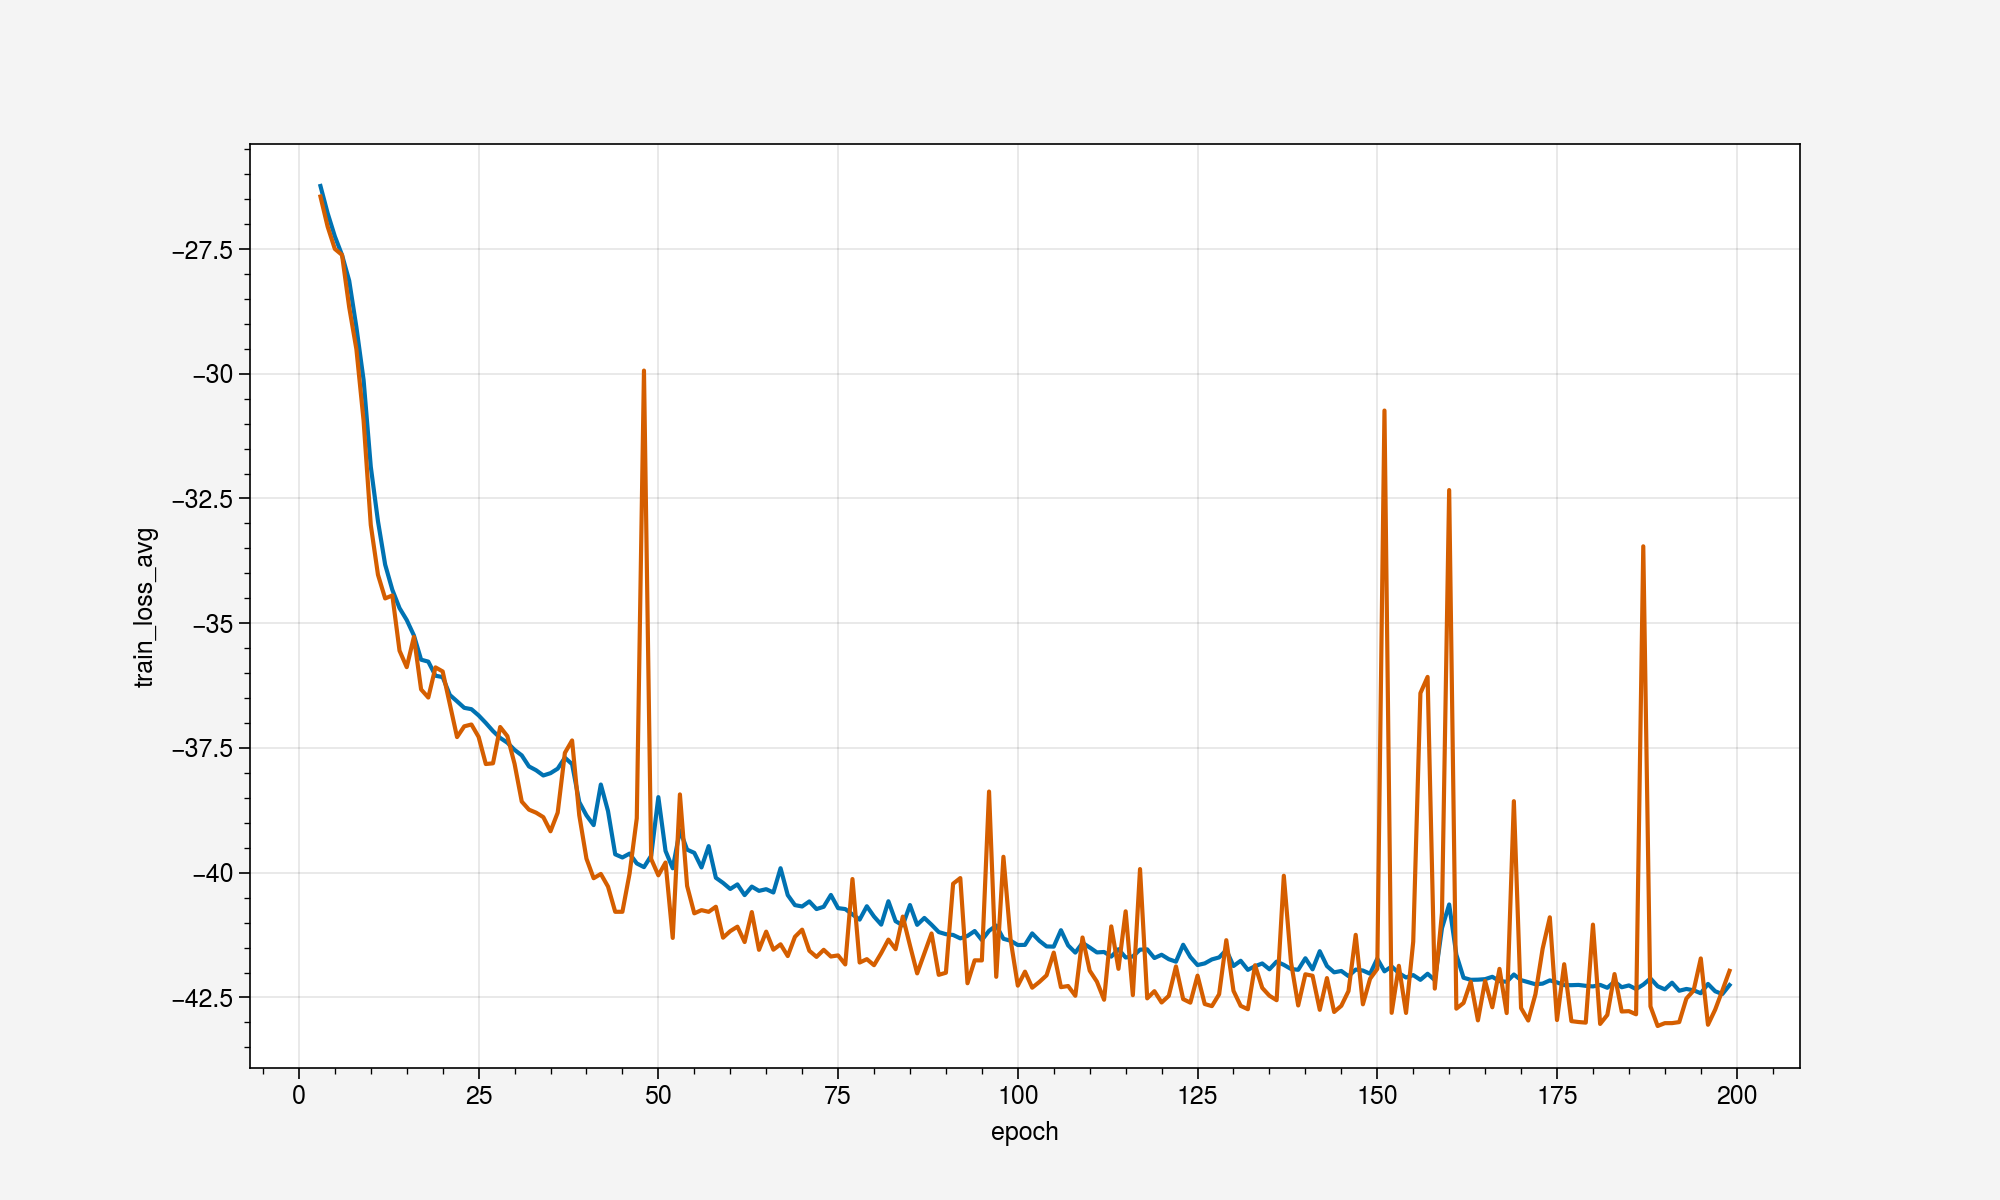

In [32]:
result_pd = pd.DataFrame()
result_pd['epoch'] = range(200)
result_pd['train_loss_avg'] = result[0].val.detach().cpu().numpy()
result_pd['validation_loss_avg'] = result[1].val.detach().cpu().numpy()

plot_line_2(y_1='train_loss_avg', y_2='validation_loss_avg', df=result_pd.iloc[3:, :], output_path=".\\imgs\\ROCKYEXO_ENABLEMDN20240630_TrainValLoss_2.png")

In [33]:
check_outlier(result[1].val.detach().cpu().numpy(), 1, 15, 3.0)

[48, 53, 77, 137, 151, 160, 169, 187]

In [34]:
np.save('D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_x.npy', test_x)
np.save('D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_y.npy', test_y)
joblib.dump(s_x, "D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_Xscaler_20240630.save")
joblib.dump(s_y, "D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_yscaler_20240630.save")

['D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_yscaler_20240630.save']

In [35]:
t_x = np.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_x.npy")
t_y = np.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\test_y.npy")
m_y = joblib.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\testData\\MDN_v3_yscaler_20240630.save")

In [42]:
model = EnsembleMDN(int(len(input_parameters) / 2), len(output_parameters), 10, 256, kernel_size=2)
init_weights(model)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("D:\\Resource\\MDN\\rockyExoplanetV3\\NoiseADD\\best_model.pth"))

<All keys matched successfully>

In [43]:
rand_idx = torch.randint(0, t_x.shape[0], size=(20000, ))

In [37]:
sampled_test_x = t_x[rand_idx]
sampled_test_y = t_y[rand_idx]

In [38]:
t_x_o, t_x_n = np.array_split(sampled_test_x, 2, axis=1)

In [44]:
model.eval()
pred = model(torch.from_numpy(t_x_o), torch.from_numpy(t_x_n))

In [45]:
mix = Mixture()
criterion = NLLLoss()
mse = nn.MSELoss()
sample = mix(pred[0], pred[1], pred[2]).sample()
print("NLLLoss: {}, MSE: {}, R2: {}".format(criterion(pred[0], pred[1], pred[2], torch.from_numpy(sampled_test_y).to('cuda')),
                                            mse(torch.from_numpy(sampled_test_y).to('cuda'), sample),
                                            r2_score(sample, torch.from_numpy(sampled_test_y).to('cuda'))))

NLLLoss: -40.95694226344078, MSE: 0.0011267872844956178, R2: 0.963899281767551


In [46]:
GMM_PDF_scaled = calculate_GMM(torch.exp(pred[0]).detach().cpu().numpy(), pred[1].detach().cpu().numpy(), pred[2].detach().cpu().numpy())

In [48]:
sampled_test_y_inverse = s_y.inverse_transform(sampled_test_y)

Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 91815 ticks ([1719.96, ..., 5392.52]), which exceeds Locator.MAXTICKS (1000).


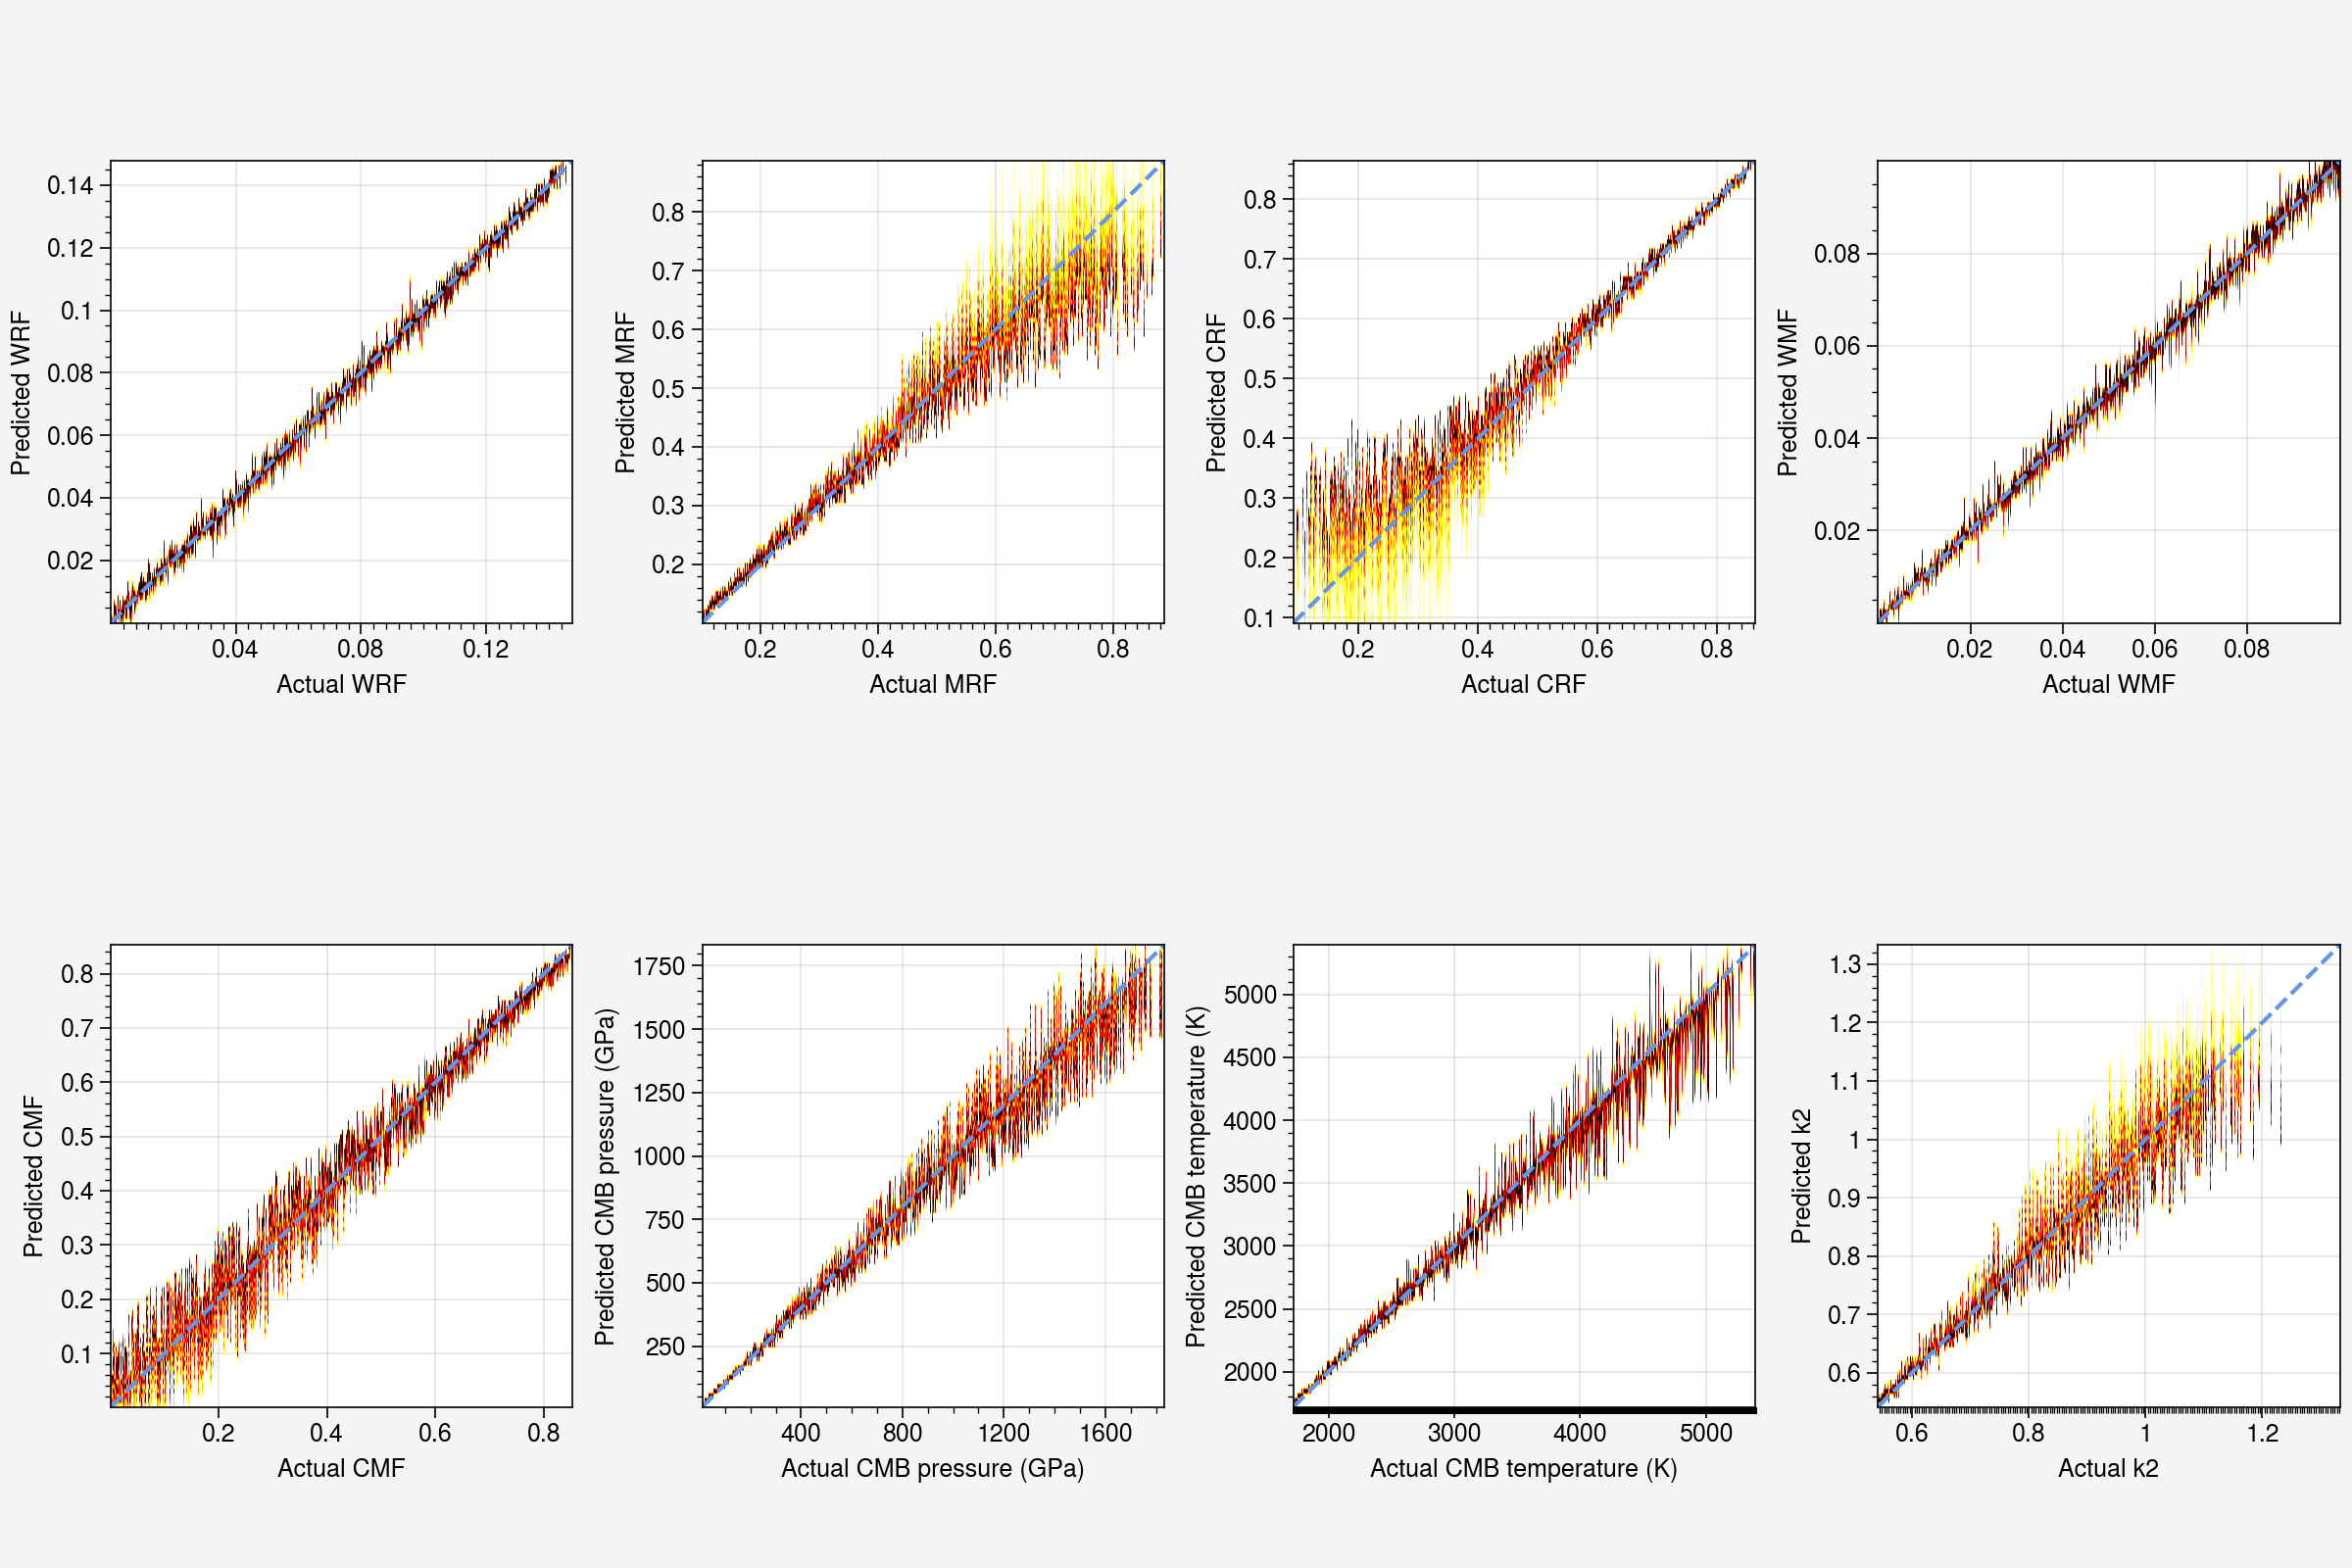

In [51]:
cmap = plt.cm.hot_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
fig, axs = pplt.subplots(
#     figsize=(4,4),
    nrows=2, ncols=4,
    share=False, 
    figsize=(12, 8)
#     tight=True,
)

output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF', 
    'CPS',
    'CTP',
    'k2'
]


xlabels = [
    "Actual WRF","Actual MRF", "Actual CRF", 
    "Actual WMF","Actual CMF", "Actual CMB pressure (GPa)", "Actual CMB temperature (K)",
    "Actual k2", 
]
ylabels = [
    "Predicted WRF","Predicted MRF", "Predicted CRF", 
    "Predicted WMF","Predicted CMF", "Predicted CMB pressure (GPa)", "Predicted CMB temperature (K)",
    "Predicted k2", 
]

xlocators = [
    0.04, 0.2, 0.2, 0.02, 0.2, 400, 1000, 0.2
]
xminorlocators = [
    0.004, 0.02, 0.02, 0.02, 40, 100, 0.04, 0.004
]

OUTPUT_DIMS = len(output_parameters)

for o in range(OUTPUT_DIMS):
    y_max = max(sampled_test_y_inverse[:, o])
    y_min = min(sampled_test_y_inverse[:, o])
    for i in range(0, GMM_PDF_scaled.shape[-1], OUTPUT_DIMS):
        tx, ty = [sampled_test_y_inverse[int(i / OUTPUT_DIMS), o], y_min]
        axs[o].imshow(
                GMM_PDF_scaled[:, o + i].reshape(-1, 1),
                cmap=cmap,
                norm=norm,
                origin='lower',
                extent=(tx, tx + 0.0001, ty, y_max)
            )

    axs[o].plot([y_min, y_max], [y_min, y_max], c='cornflowerblue', ls='--')
    axs[o].format(
        xlim=(y_min, y_max), ylim=(y_min, y_max),
        xlabel=xlabels[o], ylabel=ylabels[o],
        xlocator=xlocators[o], xminorlocator=xminorlocators[o],
        # ylocator=xlocators[o], yminorlocator=xminorlocators[o]
    )

In [49]:
# Calculate the offset of the probability density heatmap
col_dis = []
for o in range(len(output_parameters)):
    dis = 0
    for i in range(0, GMM_PDF_scaled.shape[-1], len(output_parameters)):
        test_y_current = sampled_test_y_inverse[int(i / len(output_parameters)), o]
        GMM_cal = GMM_PDF_scaled[:, o + i].reshape(-1, 1)
        offset = np.sqrt((GMM_cal - test_y_current) ** 2)
        dis += np.mean(offset)
    col_dis.append(dis / len(sampled_test_y_inverse))

In [50]:
col_dis

[0.10047666055783512,
 0.3157597439250125,
 0.5901741221056456,
 0.08566222874684314,
 0.49201439036333183,
 527.2997213978881,
 3195.9593795938945,
 0.6541963958010693]